In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

import os
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)
maxEpoch=50
if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

2022-11-11 15:24:22.757795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 15:24:23.287919: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 15:24:25.015029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nate/miniconda3/lib/:/home/nate/miniconda3/lib/:/home/nate/miniconda3/lib/
2022-11-11 15:24:25.015211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

Num GPUs Available:  0


2022-11-11 15:24:28.288188: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-11 15:24:28.288235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: blade
2022-11-11 15:24:28.288245: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: blade
2022-11-11 15:24:28.288351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-11-11 15:24:28.288382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-11-11 15:24:28.288390: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1


In [2]:
tfds.list_builders()

2022-11-11 12:13:13.655655: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


['c4',
 'c4_wsrs',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_n',
 'citrus_leaves',
 'civil_comments',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2003',
 'controlled_noisy_web_labels',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'criteo',
 'cs_restaurants',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_antmaze',
 'd4rl_mujoco_ant',
 'd4rl_mujoco_halfcheetah',
 'd4rl_mujoco_hopper',
 'd4rl_mujoco_walker2d',
 'dart',
 'davis',
 'deep1b',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'diamonds',
 'dmlab',
 'doc_nli',
 'dolphin

In [4]:
# ds = tfds.load('resisc45', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
# print(ds)



In [5]:
# ds, ds_info = tfds.load('resisc45', split='train', with_info=True)
# fig = tfds.show_examples(ds, ds_info)

# print(ds_info)

In [2]:


data_dir = pathlib.Path("/home/nate/tensorflow_datasets/downloads/manual/NWPU-RESISC45/")




In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


31500


In [8]:
airplane = list(data_dir.glob('airplane/*'))
print(airplane[0])

/home/nate/tensorflow_datasets/downloads/manual/NWPU-RESISC45/airplane/airplane_676.jpg


In [3]:
batch_size = 32
img_height = 256
img_width = 256

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31500 files belonging to 45 classes.
Using 25200 files for training.
Using 6300 files for validation.


2022-11-11 15:24:45.091462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
class_names = train_ds.class_names
print(class_names)

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']


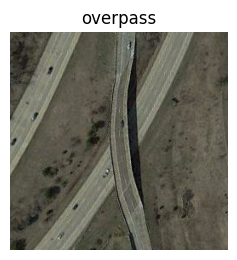

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 30))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(9, 9, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [6]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.011764707 1.0


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
num_classes = 45

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [8]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [9]:

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
163/788 [=====>........................] - ETA: 12:50 - loss: 3.4021 - accuracy: 0.1058

KeyboardInterrupt: 

In [ ]:
input_context = tf.distribute.InputContext(
    input_pipeline_id=1,  # Worker id
    num_input_pipelines=4,  # Total number of workers
)
read_config = tfds.ReadConfig(
    input_context=input_context,
)
ds = tfds.load('resisc45', split='train', read_config=read_config)

batch_size = 12
img_height = 256
img_width = 256

In [ ]:

data_dir = pathlib.Path("/home/nate/tensorflow_datasets/downloads/manual/NWPU-RESISC45/")


train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
train_ds